###### To run this code the packages lifesim and spectres must be installed

Manual:
https://lifesim.readthedocs.io/en/latest/index.html

###### Figures 2,4,5 and 6 are at the end of the notebook for a more organized and straightforward code.

In [ ]:
import lifesim
import warnings
import numpy as np
from spectres import spectres
from matplotlib.pyplot import figure, show
import matplotlib as mpl
from astropy import units as u
import matplotlib.pyplot as plt
import scienceplots
import scipy

#ignores the output of a warning message about lifesim versions, can be ignored with the latest package versions
warnings.simplefilter('ignore')

## Instrument set-up Baseline scenario

In [ ]:
## Instrument set-up BASELINE scenario

wavel = np.linspace(3.000e-6,20e-6,3000) * u.m
widths = 0.02e-6 * u.m

#setting up the bus
bus = lifesim.Bus()
bus.data.options.set_scenario('baseline')
#bus.data.options.set_scenario('optimistic')
#bus.data.options.set_scenario('pessimistic')

#or set the options manually
# kwargs = {'diameter':2, 
#           'baseline':15, 
#           'ratio':6, 
#           'throughput':5,
#           'quantum_eff':70,
#           'wl_min':4,'wl_max':18.5,
#           'bl_min':10,'bl_max':100,
#           'spec_res':20,
#           't_slew':36000,'t_efficiency':80,
#          'localzodi':'darwinsim', 'habitable':'MS',
#          'image_size': 256,
#          'wl_optimal': 15,
#          'n_plugins': 10}

#to change a factor manually:
#bus.data.options.set_manual(baseline=5)

#set-up the modules
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

#include the noise sources
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)

#connect the modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))

## Fig 1.

In [ ]:
#this cell takes quite a few minutes to run

#PARAMETERS OF THE PLANET
rad = 1.0 #earth radii

# PARAMETERS OF THE STAR
stemp = 5778 #Kelvin
sradius = 1 #Solar radii
slat = 1.3 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
zodi = 1 #zodis, examples: 1,10,100,1000

intime = 36000 #integration time in seconds, equivalent to 10 hours
intime_hours = intime/3600 #integration time in hours
baseline_planet = True #optimizes baseline for planet

# temperature range
x = np.arange(500,701) #800 is maximum effective temperature
#distance
y = np.arange(20,70)
n = 1 * u.AU; n = n.to(u.pc)

#set-up the third array
Z = np.zeros([y[-1]+1-y[0],x[-1]+1-x[0]])

X,Y = np.meshgrid(x,y)
print(np.shape(Z))

#This for loop goes through the grid 'Z' where x is the temperature and y the distance to the targets
#for every point it calculates the SNR of the target at different distances to find when it crosses the threshold
i=0
for t in x:
    j=0;
    for d in y:
        spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavel.value, width=widths.value, temp = t, radius = rad, distance = d); spec = spec / u.m**2 / u.s; spec /= widths
        planet_flux = [wavel, spec]
        ang = (n.value/d) * (360/(2*np.pi)) * 3600
        bins_snr, flux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=d, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
        Z[j,i] = np.sqrt(np.sum(bins_snr[1]**2))
        j += 1
    i += 1

In [ ]:
#The plotting cell (this one) is separated from the code so that it's more easily run and changed if necessary
#while the above cell takes long to run

plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(15,15))
plt.gca().set_aspect('auto')

cmap = mpl.colors.ListedColormap(['white', 'gray'])
bounds=[0,7,1000000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cf = ax.imshow(Z,interpolation='spline36',cmap=cmap,norm=norm)

locs,labels = plt.xticks()
labels = [float(item)+500 for item in locs]
plt.xticks(locs,labels)

locs,labels = plt.yticks()
labels = [float(item)+20 for item in locs]
plt.yticks(locs,labels)

plt.xlim([0,200])
plt.ylim([10,50])
#ax.invert_yaxis()
ax.set_xlabel("Planet's Temperature (K)",size=20); ax.set_ylabel("Distance (pc)",size=20)
#ax.grid(color='gray', linestyle='-', linewidth=0.5)

#known stellar associations
st_a = [37,48,50,53]
plt.axhline(37-20,color='red',linestyle="--",linewidth='0.6',label=r"$\beta Pictoris$")
plt.axhline(43-20,color='blue',linestyle="--",linewidth='0.6',label=r"$\beta Tucanae$")
plt.axhline(48-20,color='orange',linestyle="--",linewidth='0.6',label="Tucana Horologium")
plt.axhline(53-20,color='green',linestyle="--",linewidth='0.6',label="TW Hydrae")

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True, fontsize=15)

plt.show()

In [ ]:
#SECOND PLOT of Figure 1

# temperature
x1 = np.arange(660,800) #800 is maximum effective temperature
#distance
y1 = np.arange(70,105)
n = 1 * u.AU; n = n.to(u.pc)

#set-up the third array
Z1 = np.zeros([y1[-1]+1-y1[0],x1[-1]+1-x1[0]])

X1,Y1 = np.meshgrid(x,y)
print(np.shape(Z1))

i=0
for t in x1:
    j=0;
    for d in y1:
        spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavel.value, width=widths.value, temp = t, radius = rad, distance = d); spec = spec / u.m**2 / u.s; spec /= widths
        planet_flux = [wavel, spec]
        ang = (n.value/d) * (360/(2*np.pi)) * 3600
        SNR = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=d, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)[0][1]
        Z1[j,i] = np.sqrt(np.sum(SNR**2))
        j += 1
    i += 1
    print(i)

In [ ]:
#this one is also separated for the same reasons as the ones above

fig, ax = plt.subplots(figsize=(15,15))

cmap = mpl.colors.ListedColormap(['white', 'gray'])
bounds=[0,7,1000000] #set-up bounds at the detection threshold
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cf = ax.imshow(Z1,interpolation='spline36',cmap=cmap,norm=norm)
#cbar = fig.colorbar(cf, ax=ax, ticks = 7)

locs,labels = plt.xticks()
labels = [float(item)+660 for item in locs]
plt.xticks(locs,labels)

locs,labels = plt.yticks()
labels = [float(item)+70 for item in locs]
plt.yticks(locs,labels)

plt.xlim([0,139])
plt.ylim([0,30])

ax.set_xlabel("Planet's Temperature (K)",size=20); ax.set_ylabel("Distance (pc)",size=20)

#known stellar associations
plt.axhline(92-70,color='red',linestyle="--",linewidth='1',label="32 Orionis")
plt.axhline(94-70,color='blue',linestyle="--",linewidth='1',label=r"$\eta Chamaleontis$")
plt.axhline(99-70,color='green',linestyle="--",linewidth='1',label=r"$\chi 1 For$")


ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True,fontsize=15)

plt.show()

## Fig 3.

In [ ]:
#S/N curve for an M-STAR
warnings.simplefilter('ignore')

distance = np.arange(20,100) 

#define a detection threshold:
threshold = 7

#PARAMETERS OF THE PLANET
rad = 1 #earth radii
temperature = 1500 #Kelvin

# PARAMETERS OF THE M STAR AD Leonis
stemp = 3390 #Kelvin
sradius = 0.4 #Solar radii
slat = 1.3 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
zodi = 1 #zodis, examples: 1,10,100,1000

intime = 5*60 #integration time in seconds
intime_hours = intime/3600 #integration time in hours
baseline_planet = False #optimizes baseline for planet

#this loop finds the S/N at every distance in the range and saves it into a list
SN = [];
for dist in distance:
    #flux of the planet at temperature T and distance dist, at fixed Radius
    spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavel.value, width=widths.value, temp= temperature, radius = rad, distance = dist); spec = spec / u.m**2 / u.s; spec /= widths
    planet_flux = [wavel, spec]
    orb1 = 0.13; n = orb1 * u.AU; n = n.to(u.pc)
    ang = (n.value/dist) * (360/(2*np.pi)) * 3600
    #SNR per bin
    bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
    SNR = np.sqrt(np.sum(bins_snr[1]**2)); SN.append(SNR)

distance = np.arange(20,len(SN)+20)

In [ ]:
#S/N curve for SOLAR LIKE STAR
warnings.simplefilter('ignore')
#temperature of the planet
distance = np.arange(20,100) 

#define a detection threshold:
threshold = 7

#PARAMETERS OF THE PLANET
rad = 1 #earth radii
temperature = 1500

# PARAMETERS OF THE STAR
stemp = 5570 #Kelvin
sradius = 1.0 #Solar radii
slat = 1.3 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
zodi = 1 #zodis, examples: 1,10,100,1000

intime = 5*60 #integration time in seconds
intime_hours = intime/3600 #integration time in hours
baseline_planet = False #optimizes baseline for planet

SN1 = [];
for dist in distance:
    #flux of the planet at temperature T and distance dist, at fixed Radius
    spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavel.value, width=widths.value, temp= temperature, radius = rad, distance = dist); spec = spec / u.m**2 / u.s; spec /= widths
    planet_flux = [wavel, spec]
    orb = 1
    n = orb * u.AU; n = n.to(u.pc)
    ang = (n.value/dist) * (360/(2*np.pi)) * 3600
    #SNR per bin
    bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
    SNR = np.sqrt(np.sum(bins_snr[1]**2)); SN1.append(SNR)
distance = np.arange(20,len(SN1)+20)

SN2= []
for dist in distance:
    #flux of the planet at temperature T and distance dist, at fixed Radius
    spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavel.value, width=widths.value, temp= temperature, radius = rad, distance = dist); spec = spec / u.m**2 / u.s; spec /= widths
    planet_flux = [wavel, spec]
    orb = 0.13
    n = orb * u.AU; n = n.to(u.pc)
    ang = (n.value/dist) * (360/(2*np.pi)) * 3600
    #SNR per bin
    bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
    SNR = np.sqrt(np.sum(bins_snr[1]**2)); SN2.append(SNR)

In [ ]:
#plotting cell

#stellar associations lines
st_a = [37,53,94]; names = [r"$\beta$ Pictoris","TW Hydrae","eta chamalaeontis"]; colors = ["purple","orange","green"]

plt.style.use(['science','ieee','high-vis'])

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(distance,SN,label=f"M-type {orb1}AU"); frame.grid()
frame.plot(distance,SN1,label=f"Solar-like 1AU",linestyle='-')
frame.plot(distance,SN2,label=f"Solar-like {orb}AU",linestyle='-')
frame.set_title(f"S/N Curve of 1500K planet",fontsize=10)
for n in range(3):
    frame.axvline(st_a[n], linestyle = "--", linewidth = 1, color = colors[n])
frame.set_xlabel("Distance (pc)",fontsize=10); frame.set_ylabel("S/N",fontsize=10)
frame.axhline(threshold, linestyle='--',linewidth=1,color='gray')
frame.legend()
show()

## Fig 7.

In [ ]:
#temperatures of the planet's blackbodies
t = [276,700,1500] #Kelvin

#planet parameters
rad = 1 #earth radii
dist = 10.0 #parsec
orbit = 1 #AU

#star parameters
sradius = 1 #solar radii
stemp = 5780
slat = 0.78
zodi = 3

intime = 3600 #integration time in seconds
n = orbit * u.AU; n = n.to(u.pc) #radius of orbit
ang = (n.value/dist) * (360/(2*np.pi)) * 3600

for i in range(len(t)):
    spec = lifesim.util.radiation.black_body(mode='planet', bins=wavel.value, width=widths.value, temp=t[i], radius=rad,distance=dist)
    spec = spec / u.m ** 2 / u.s; spec /= widths
    locals()[f"spec{i}"] = spec

In [ ]:
#plotting cell

n=[0,1,2]
fig = figure()
frame = fig.add_subplot(1, 1, 1)
plt.style.use(['science', 'ieee'])
lambdaa = wavel * 1e6
linestyles = ['-','-.','dotted']
for i in n:
    spec = locals()[f"spec{i}"]
    frame.plot(lambdaa, np.log10(spec.value), label=f"{t[n.index(i)]}K",linestyle=linestyles[n.index(i)], color='black')

planet_flux = [wavel, spec]

# optimistic wavelengths lines
frame.axvline(3, color='green', linestyle='--', linewidth=1);
frame.axvline(20, color='green', linestyle='--', linewidth=1)

# baseline wavelengths lines
frame.axvline(4, color='blue', linestyle='--', linewidth=1);
frame.axvline(18.5, color='blue', linestyle='--', linewidth=1)

# pessimistic wavelengths lines
frame.axvline(6, color='red', linestyle='--', linewidth=1);
frame.axvline(17, color='red', linestyle='--', linewidth=1)

frame.grid()
frame.set_xlabel(r"$\lambda$ [microns]")
frame.set_ylabel(r"$log_{10}$(Photon Flux)")
frame.legend()
show()

## Fig 8

In [ ]:
#PLANET parameters
ptemp = 700 #Kelvin
pradius = 1.0 #earth radii
dist = 37.0 #parsec
orbit = 0.13 #AU

#hotter planet parameters
ptemp2 = 400 #Kelvin

plt.style.use(['science','ieee'])


#STAR parameters
stemp = 3390 #Kelvin
sradius = 0.4 #Solar radii
slat = 0.78 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
zodi = 3 #zodis, examples: 1,10,100,1000

intime=54000

scenarios = ['pessimistic','baseline','optimistic']
couleur = ['red','blue','green']

for scenario in scenarios:
    #Instrument set-up, choose observing scenario
    bus = lifesim.Bus()
    #observing scenarios: optimistic, baseline, pessimistic
    bus.data.options.set_scenario(scenario)
    #change the spectral resolution to 50
    bus.data.options.set_manual(spec_res=50)
    detection_threshold = 7
    baseline_planet = True #optimizes baseline for planet
    instrument = lifesim.Instrument(name='inst')
    bus.add_module(instrument)
    transm = lifesim.TransmissionMap(name='transm')
    bus.add_module(transm)
    #include the noise sources
    exozodi = lifesim.PhotonNoiseExozodi(name='exo')
    bus.add_module(exozodi)
    localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
    bus.add_module(localzodi)
    star_leak = lifesim.PhotonNoiseStar(name='star')
    bus.add_module(star_leak)
    #connect the modules
    bus.connect(('inst', 'transm'))
    bus.connect(('inst', 'exo'))
    bus.connect(('inst', 'local'))
    bus.connect(('inst', 'star'))
    bus.connect(('star', 'transm'))
    
    #wavelength range for the planet's spectrum
    wavelength = np.linspace(3.0e-6,20e-6,3000) * u.m
    widths = 0.02e-6 * u.m
    #PLANET's BLACKBODY spectra
    spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavelength.value, width=widths.value, temp= ptemp, radius = pradius, distance = dist)
    spec = spec / u.m**2 / u.s; spec /= widths
    planet_flux = [wavelength, spec]

    spec2 = lifesim.util.radiation.black_body(mode = 'planet', bins=wavelength.value, width=widths.value, temp= ptemp2, radius = pradius, distance = dist)
    spec2 = spec2 / u.m**2 / u.s; spec2 /= widths
    planet_flux2 = [wavelength, spec2]
    
    n = orbit * u.AU; n = n.to(u.pc) #radius of orbit
    ang = (n.value/dist) * (360/(2*np.pi)) * 3600
    bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
    
    #re-scale the flux to the same number of bins 
    planet_flux_r = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],spec_wavs=planet_flux[0].value,spec_fluxes=planet_flux[1].value,edge_mode=True)
    planet_flux_r2 = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],spec_wavs=planet_flux2[0].value,spec_fluxes=planet_flux2[1].value,edge_mode=True)

    #noise distribution
    #the ratio is our sigma
    ratio = planet_flux_r / bins_snr[1]
    noise = np.random.normal(0,ratio,size=planet_flux_r.shape)
    #the fill-inbetween
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    frame.fill_between(bins_snr[0]*1e6,planet_flux_r-ratio,planet_flux_r+ratio,color='gray',alpha=0.1,label='1-$\sigma$')
    #plot and scatter
    frame.plot(bins_snr[0]*1e6, planet_flux_r,color='black',label=f"{ptemp}K")
    frame.plot(bins_snr[0]*1e6,planet_flux_r2,color=couleur[scenarios.index(scenario)],label=f"{ptemp2}K",linestyle='-')
    frame.scatter(bins_snr[0]*1e6, planet_flux_r+noise,c='black',marker='.',label='Simulation')
    frame.errorbar(bins_snr[0]*1e6,planet_flux_r+noise,yerr=abs(noise),c='black',capsize=2,ls='none')
    #set-up graph
    frame.set_title(f"{scenario}")
    frame.set_xlabel('$\lambda$ [microns]')
    frame.set_ylabel(r"Photon Flux $ph / m^3 s^1$")
    frame.legend()
    show()
    
    locals()[f"f_diff_sigma{scenario}"] = np.divide(abs(planet_flux_r - planet_flux_r2),planet_flux_r/bins_snr[1])
    locals()[f"bins_snr_{scenario}"] = bins_snr[0]

fig = figure(figsize=(10,10))
frame = fig.add_subplot(1,1,1)
frame.step(bins_snr_pessimistic*1e6, f_diff_sigmapessimistic,color='red',label='Pessimistic',linestyle='-')
frame.step(bins_snr_baseline*1e6,f_diff_sigmabaseline,color='blue',label='Baseline',linestyle='-')
frame.step(bins_snr_optimistic*1e6, f_diff_sigmaoptimistic, color='green',label='Optimistic',linestyle='-')
frame.set_ylabel(f"$(F{ptemp} - F{ptemp2})/\sigma{ptemp})$")
frame.set_xlabel('Wavelength [microns]')
frame.set_ylim(0); frame.set_xlim(3,20); frame.legend()

show()

#save array for later plot on statistical differences compared
bins_snr_baseline1 = bins_snr_baseline
f_diff_sigmabaseline1 = f_diff_sigmabaseline

## Fig 9.

In [ ]:
#PLANET parameters
ptemp = 700 #Kelvin
pradius = 1.0 #earth radii
dist = 37.0 #parsec
orbit = 0.13 #AU

#hotter planet parameters
ptemp2 = 1000 #Kelvin


#STAR parameters
stemp = 3390 #Kelvin
sradius = 0.4 #Solar radii
slat = 0.78 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
zodi = 3 #zodis, examples: 1,10,100,1000

scenarios = ['pessimistic','baseline','optimistic']
couleur = ['red','blue','green']
plt.style.use(['science'])

for scenario in scenarios:
    #Instrument set-up, choose observing scenario
    bus = lifesim.Bus()
    #observing scenarios: optimistic, baseline, pessimistic
    bus.data.options.set_scenario(scenario)
    bus.data.options.set_manual(spec_res=50)
    detection_threshold = 7
    baseline_planet = True #optimizes baseline for planet
    instrument = lifesim.Instrument(name='inst')
    bus.add_module(instrument)
    transm = lifesim.TransmissionMap(name='transm')
    bus.add_module(transm)
    #include the noise sources
    exozodi = lifesim.PhotonNoiseExozodi(name='exo')
    bus.add_module(exozodi)
    localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
    bus.add_module(localzodi)
    star_leak = lifesim.PhotonNoiseStar(name='star')
    bus.add_module(star_leak)
    #connect the modules
    bus.connect(('inst', 'transm'))
    bus.connect(('inst', 'exo'))
    bus.connect(('inst', 'local'))
    bus.connect(('inst', 'star'))
    bus.connect(('star', 'transm'))
    
    #wavelength range for the planet's spectrum
    wavelength = np.linspace(3.0e-6,20e-6,3000) * u.m
    widths = 0.02e-6 * u.m
    #PLANET's BLACKBODY spectra
    spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavelength.value, width=widths.value, temp= ptemp, radius = pradius, distance = dist)
    spec = spec / u.m**2 / u.s; spec /= widths
    planet_flux = [wavelength, spec]

    spec2 = lifesim.util.radiation.black_body(mode = 'planet', bins=wavelength.value, width=widths.value, temp= ptemp2, radius = pradius, distance = dist)
    spec2 = spec2 / u.m**2 / u.s; spec2 /= widths
    planet_flux2 = [wavelength, spec2]
    
    n = orbit * u.AU; n = n.to(u.pc) #radius of orbit
    ang = (n.value/dist) * (360/(2*np.pi)) * 3600
    intime=18000
    bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
    
    #re-scale the fluxes
    planet_flux_r = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],spec_wavs=planet_flux[0].value,spec_fluxes=planet_flux[1].value,edge_mode=True)
    planet_flux_r2 = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],spec_wavs=planet_flux2[0].value,spec_fluxes=planet_flux2[1].value,edge_mode=True)

    #noise distribution
    #the ratio is sigma
    ratio = planet_flux_r / bins_snr[1]
    noise = np.random.normal(0,ratio,size=planet_flux_r.shape)
    #the fill-inbetween
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    frame.fill_between(bins_snr[0]*1e6,planet_flux_r-ratio,planet_flux_r+ratio,color='gray',alpha=0.1,label='1-$\sigma$')
    #plot and scatter
    frame.plot(bins_snr[0]*1e6, planet_flux_r,color='black',label=f"{ptemp}K")
    frame.plot(bins_snr[0]*1e6,planet_flux_r2,color=couleur[scenarios.index(scenario)],label=f"{ptemp2}K")
    frame.scatter(bins_snr[0]*1e6, planet_flux_r+noise,c='black',marker='.',label='Simulation')
    frame.errorbar(bins_snr[0]*1e6,planet_flux_r+noise,yerr=abs(noise),c='black',capsize=2,ls='none')
    #set-up graph
    frame.set_title(f"{scenario}")
    frame.set_xlabel('$\lambda$ [microns]')
    frame.set_ylabel(r"Photon Flux $ph / m^3 s^1$")
    frame.legend()
    show()
    locals()[f"f_diff_sigma{scenario}"] = np.divide(abs(planet_flux_r - planet_flux_r2),planet_flux_r/bins_snr[1])
    locals()[f"bins_snr_{scenario}"] = bins_snr[0]

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.step(bins_snr_pessimistic*1e6, f_diff_sigmapessimistic,color='red',label='Pessimistic',linestyle='-')
frame.step(bins_snr_baseline*1e6,f_diff_sigmabaseline,color='blue',label='Baseline',linestyle='-')
frame.step(bins_snr_optimistic*1e6, f_diff_sigmaoptimistic, color='green',label='Optimistic',linestyle='-')
frame.set_ylabel(f"$(F{ptemp} - F{ptemp2})/\sigma{ptemp})$")
frame.set_xlabel('Wavelength [microns]')
frame.set_ylim(0); frame.set_xlim(3,20); frame.legend()
show()

#save array for statistical difference plot of 2 baselines compared
bins_snr_baseline2 = bins_snr_baseline
f_diff_sigmabaseline2 = f_diff_sigmabaseline

## Fig 10.

In [ ]:
#plot comparing the statistical difference at the temperature cases for the baseline scenario
#Figures 8 and 9 must have been plotted for this cell to work

plt.style.use(['science'])
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.step(bins_snr_baseline1*1e6,f_diff_sigmabaseline1,color='blue',label='700 - 400 K')
frame.step(bins_snr_baseline2*1e6,f_diff_sigmabaseline2,color='blue',linestyle=':',label='700 - 1000 K')
frame.set_ylabel(f"$(F700 - F2)/\sigma700)$")
frame.set_xlabel('Wavelength [microns]')
frame.set_ylim(0); frame.set_xlim(3,20)
frame.axhline(5,color='gray',linestyle='--',label=r'5$\sigma$')
frame.legend()
#plt.savefig(f"statisticaldiffbaseline.pdf",format='pdf')
show()

## Fig 11.

In [ ]:
#grid of values to calculate statistical difference at
T = [1100,1000,900,800,700,600,500,400,300]
time = [3600,9000,18000, 27000, 36000, 45000,54000,63000,72000] #seconds
time_hours = [x/3600 for x in time]

#PLANET parameters
ptemp = 700 #Kelvin
pradius = 1.0 #earth radii
dist = 37.0 #parsec at Beta Pictoris distance
orbit = 0.13 #AU

#STAR parameters
stemp = 3390 #Kelvin
sradius = 0.4 #Solar radii
slat = 0.78 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
zodi = 3 #zodis, examples: 1,10,100,1000

sigma = np.zeros([len(T),len(time)])
plt.style.use(['science'])

#Instrument set-up, choose observing scenario
bus = lifesim.Bus()
#observing scenarios: optimistic, baseline, pessimistic
bus.data.options.set_scenario('baseline')
bus.data.options.set_manual(spec_res=50)
detection_threshold = 7
baseline_planet = True #optimizes baseline for planet
instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)
#include the noise sources
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)
#connect the modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))

#wavelength range for the planet's spectrum
wavelength = np.linspace(3.0e-6,20e-6,3000) * u.m
widths = 0.02e-6 * u.m

i=0;j=0
for temperature in T:
    for intime in time:
        #PLANET's BLACKBODY spectra
        spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavelength.value, width=widths.value, temp= ptemp, radius = pradius, distance = dist)
        spec = spec / u.m**2 / u.s; spec /= widths
        planet_flux = [wavelength, spec]

        spec2 = lifesim.util.radiation.black_body(mode = 'planet', bins=wavelength.value, width=widths.value, temp= temperature, radius = pradius, distance = dist)
        spec2 = spec2 / u.m**2 / u.s; spec2 /= widths
        planet_flux2 = [wavelength, spec2]

        n = orbit * u.AU; n = n.to(u.pc) #radius of orbit
        ang = (n.value/dist) * (360/(2*np.pi)) * 3600
        bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=intime)
        
        #re-scale the fluxes
        planet_flux_r = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],spec_wavs=planet_flux[0].value,spec_fluxes=planet_flux[1].value,edge_mode=True)
        planet_flux_r2 = spectres(new_wavs=instrument.data.inst['wl_bin_edges'],spec_wavs=planet_flux2[0].value,spec_fluxes=planet_flux2[1].value,edge_mode=True)

        #noise distribution, the ratio is sigma
        ratio = planet_flux_r / bins_snr[1]
        f_diff_sigma = np.divide(abs(planet_flux_r - planet_flux_r2),planet_flux_r/bins_snr[1])
        peak = max(f_diff_sigma)
        sigma[i,j] = peak
        j += 1
    
    j = 0; i +=1

from matplotlib import cm

fig = figure(figsize=(10,5))
frame = fig.add_subplot(1,1,1)

#scatter the datapoints location
x,y = np.meshgrid(time,T)

con = plt.contourf(x, y, sigma, levels=20, linewidths=0.5,linestyle='-', cmap='viridis')
plt.colorbar(label=r"$\sigma$")

#draw a line at 5 sigmas
CS = plt.contour(x, y, sigma, [5],colors='white')
plt.clabel(CS,inline=True,colors='white')

frame.set_xlabel("Integration time (hours)")
frame.set_ylabel("Temperature (Kelvin)")

frame.axhline(700,c='red',linestyle='--',label=r'0 $\sigma$')

axes_value = np.around(time_hours,0)
frame.set_xticks(time,axes_value)
frame.legend()

#plt.savefig("contour700.pdf",format='pdf')

show()

## Fig 2. 

#### For figures 2,4,5 and 6 to find the integration time necessary for detection one can use the following snippet of code. It outputs one result per specific case, by changing the following instrument set-up, distance to targets (and ecliptic latitude) and host-star and/or planet parameters, the values for the plots were found.

In [ ]:
#first the instrument set-up
wavel = np.linspace(3.000e-6,20e-6,3000) * u.m
widths = 0.02e-6 * u.m

#setting up the bus
bus = lifesim.Bus()

#choose observing scenario
bus.data.options.set_scenario('baseline')
#bus.data.options.set_scenario('pessimistic')
#bus.data.options.set_scenario('optimistic')

instrument = lifesim.Instrument(name='inst')
bus.add_module(instrument)
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

#include the noise sources
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)

#connect the modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))

warnings.simplefilter('ignore')

#define a detection threshold:
threshold = 7

#PARAMETERS OF THE PLANET
rad = 1.0 #earth radii
temperature = 10000 #Kelvin
orbit = 1 #AU

# PARAMETERS OF THE HOST STAR
stemp = 5780 #Kelvin
sradius = 1 #Solar radii

slat = 1.3 #ecliptic latitude in radians 45deg = 0.78; 90deg = 1.57
#beta Pictoris and eta Chamaleontis = 1.3 | TW Hydrae = 0.65

zodi = 1 #zodis, examples: 1,10,100,1000


#distance planet-host star system to the Sun
dist = 37 #parsecs

#beta Pictoris     = 37 pc
#TW Hydrae         = 53 pc
#eta Chamaeleontis = 94 pc

#for the integration time you can choose a sensible range to perform the simulations in, for each integration time the loop runs to find the SNR
intime = np.arange(1,35000) #integration times in minutes
intime = intime*60 #integration time in seconds
baseline_planet = False #optimizes baseline for planet

for time in intime:
    #flux of the planet at temperature T and distance dist, at fixed Radius
    spec = lifesim.util.radiation.black_body(mode = 'planet', bins=wavel.value, width=widths.value, temp= temperature, radius = rad, distance = dist); spec = spec / u.m**2 / u.s; spec /= widths
    planet_flux = [wavel, spec]
    n = orbit * u.AU; n = n.to(u.pc)
    ang = (n.value/dist) * (360/(2*np.pi)) * 3600
    #SNR per bin
    bins_snr, pflux, noise = instrument.get_spectrum(temp_s=stemp, radius_s=sradius, lat_s=slat, z=zodi, distance_s=dist, angsep=ang, flux_planet_spectrum=planet_flux, integration_time=time)
    SNR = np.sqrt(np.sum(bins_snr[1]**2))
    if SNR >= threshold:
        final = time
        print(f"Minimum integration time for detection: {final/60} minutes")
        break

### Table of Results for Figure 2 

The table below visualizes the results obtained from the above snippet of code for the following figure. All results for the integration time are in minutes and are used in the plot just below the table. This is the same for all following tables.

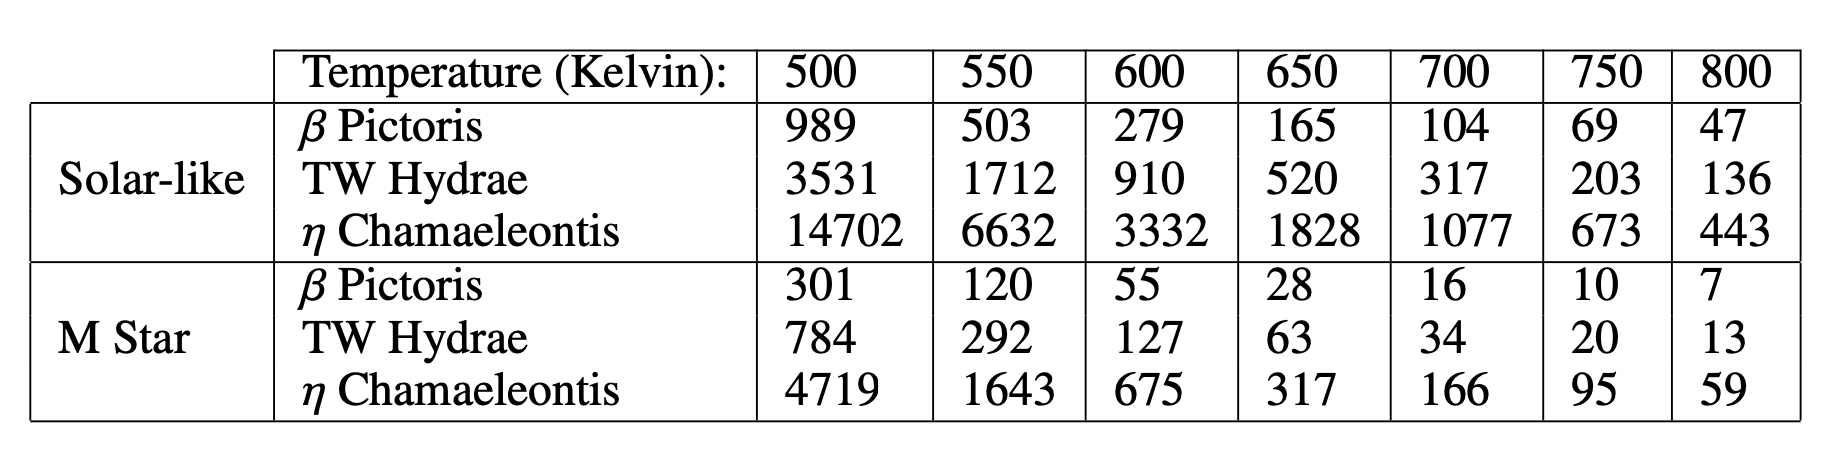

In [ ]:
plt.style.use(['science','ieee'])

T = ([500,550,600,650,700,750,800])

#results for a solar-like host star
beta_s = ([989,503,279,165,104,69,47]); tw_s = ([3531,1712,910,520,317,203,136]); cha_s = ([14702,6632,3332,1828,1077,673,443])
#results for an M star (AD Leonis)
beta_m = ([301,120,55,28,16,10,7]); tw_m = ([784,292,127,63,34,20,13]); cha_m = ([4719,1643,675,317,166,95,59])

fig = figure()
frame = fig.add_subplot(1,1,1)

#plot the lines for each association
frame.plot(T,cha_s,'-o',markersize='2',color='green',linestyle='--')
frame.plot(T,cha_m,'-o',markersize='2',color='green',linestyle='-',label=r"$\eta$ Chamaleontis")

frame.plot(T,beta_s,'-o',markersize='2',color='red',linestyle='--')
frame.plot(T,beta_m,'-o',markersize='2',color='red',linestyle='-',label=r"$\beta$ Pictoris")

frame.plot(T,tw_s,'-o',markersize='2',color='blue',linestyle='--')
frame.plot(T,tw_m,'-o',markersize='2',color='blue',linestyle='-',label="TW Hydrae")


frame.set_xlabel("Temperature (Kelvin)",fontsize=8); frame.set_ylabel("Integration Time (minutes)",fontsize=8)
frame.set_title(r"")
frame.set_ylim([-400,7000])
frame.grid()
frame.legend()


show()

## Fig 4.

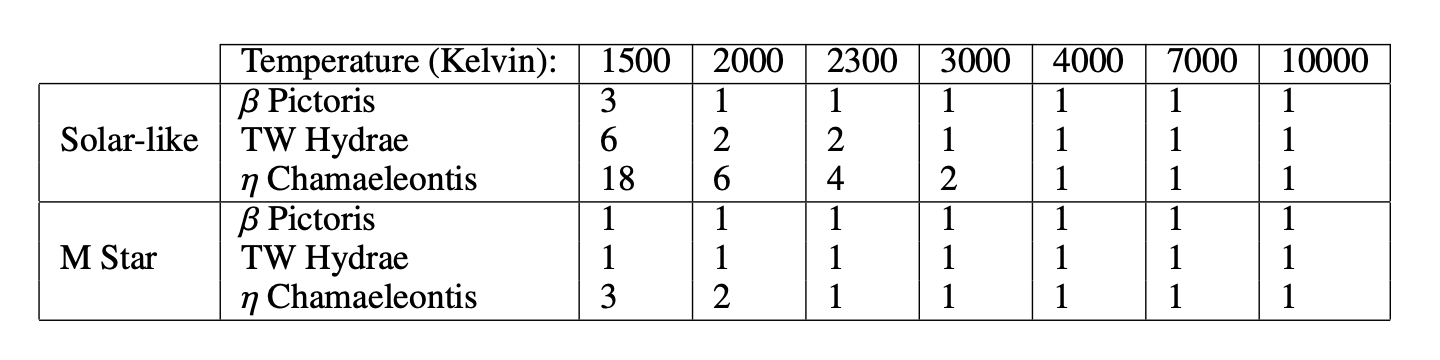

In [ ]:
plt.style.use(['science','ieee'])

T = ([1500,2000,2300,3000,4000,7000,10000])

#planet at 1AU from solar-like star
beta_b = ([3,1,1,1,1,1,1]); tw_b = ([6,2,2,1,1,1,1]); cha_b = ([18,6,4,2,1,1,1])

#planet orbiting M-star
beta_bM = ([1,1,1,1,1,1,1]); tw_bM = ([1,1,1,1,1,1,1]); cha_bM = ([3,2,1,1,1,1,1])

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.set_xlim(1450,4200)

#plot the lines for each association
frame.plot(T,cha_b,'-o',markersize='1',color='green',linestyle='--')
frame.plot(T,cha_bM,'-o',markersize='1',label=r"$\eta$ Chamaleontis",color='green')

frame.plot(T,tw_b,'-o',markersize='1',color='blue',linestyle='--')
frame.plot(T,tw_bM,'-o',markersize='1',label=r"TW Hydrae",color='blue')

frame.plot(T,beta_b,'-o',markersize='1',color='red',linestyle='--')
frame.plot(T,beta_bM,'-o',markersize='1',label=r"$\beta$ Pictoris",color='red')

frame.set_xlabel("Temperature (Kelvin)",fontsize=8); frame.set_ylabel("Integration Time (minutes)",fontsize=8)
frame.legend(); frame.grid()

show()

## Fig 5.

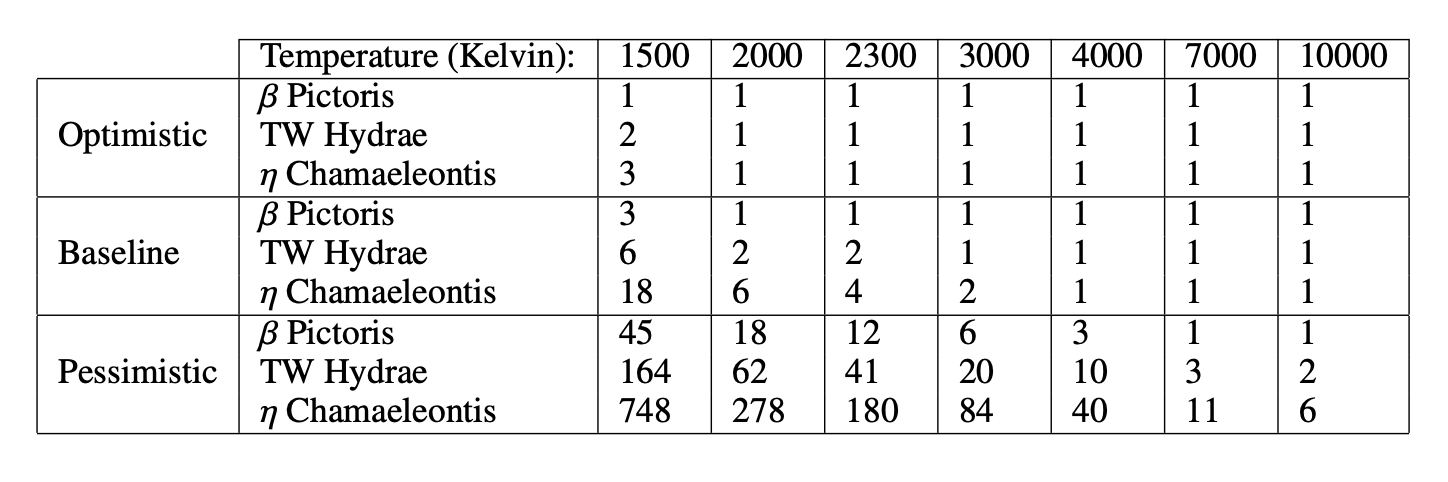

In [ ]:
plt.style.use(['science','ieee'])

#planet at 1AU from solar-like star
T = ([1500,2000,2300,3000,4000,7000,10000])

#BASELINE results for each stellar association
beta_b = ([3,1,1,1,1,1,1]); tw_b = ([6,2,2,1,1,1,1]); cha_b = ([18,6,4,2,1,1,1])
#PESSIMISTIC results for each stellar association
beta_p = ([45,18,12,6,3,1,1]); tw_p = ([164,62,41,20,10,3,2]); cha_p =([748,278,180,84,40,11,6])
#OPTIMISTIC results for each stellar association
beta_o = ([1,1,1,1,1,1,1]); tw_o = ([2,1,1,1,1,1,1]); cha_o = ([3,1,1,1,1,1,1])

fig = figure()
frame = fig.add_subplot(1,1,1)

#for plotting the Integration times were logged for a clearer plot
frame.plot(T,np.log10(cha_o),'-o',markersize='1',color='green',linestyle='dotted')
frame.plot(T,np.log10(cha_b),'-o',markersize='1',color='green',label=r"$\eta$ Chamaeleontis",linestyle='-')
frame.plot(T,np.log10(cha_p),'-o',markersize='1',color='green',linestyle='--')

frame.plot(T,np.log10(tw_o),'-o',markersize='1',color='blue',linestyle='dotted')
frame.plot(T,np.log10(tw_b),'-o',markersize='1',label=r"TW Hydrae",color='blue',linestyle='-')
frame.plot(T,np.log10(tw_p),'-o',markersize='1',color='blue',linestyle='--')

frame.plot(T,np.log10(beta_o),'-o',markersize='1',color='red',linestyle='dotted')
frame.plot(T,np.log10(beta_b),'-o',markersize='1',label=r"$\beta$ Pictoris",color='red',linestyle='-')
frame.plot(T,np.log10(beta_p),'-o',markersize='1',color='red',linestyle='--')

#the y axis is logged but the values marked are in the original minutes for an easier read
axes_value = np.around([1,10**0.5,10**1,10**1.5,10**2,10**2.5,10**3],0)
frame.set_yticks([0,0.5,1,1.5,2.0,2.5,3],axes_value)

frame.set_xlabel("Temperature (Kelvin)",fontsize=8); frame.set_ylabel("Integration Time (minutes)",fontsize=8)
frame.legend(); frame.grid()

show()

## Fig 6.

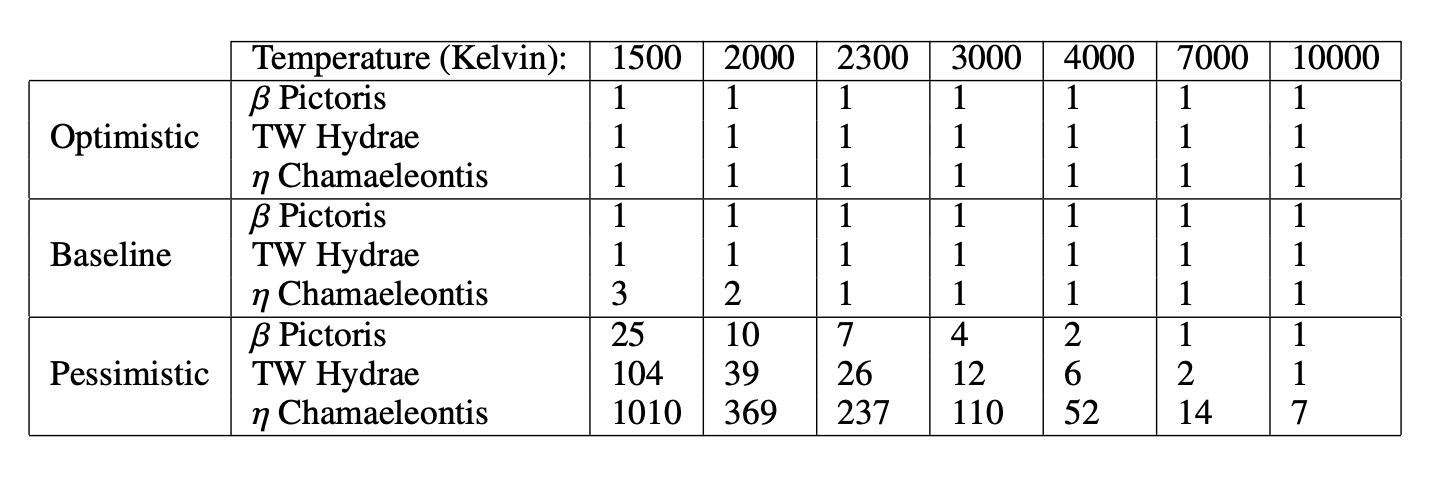

In [ ]:
plt.style.use(['science','ieee'])
warnings.simplefilter('ignore')

#planet orbiting M-star
T = ([1500,2000,2300,3000,4000,7000,10000])

#BASELINE results for each stellar association
beta_b = ([1,1,1,1,1,1,1]); tw_b = ([1,1,1,1,1,1,1]); cha_b = ([3,2,1,1,1,1,1])
#PESSIMISTIC results for each stellar association
beta_p = ([25,10,7,4,2,1,1]); tw_p = ([104,39,26,12,6,2,1]); cha_p =([1010,369,237,110,52,14,7])
#OPTIMISTIC results for each stellar association
beta_o = ([1,1,1,1,1,1,1]); tw_o = ([1,1,1,1,1,1,1]); cha_o = ([1,1,1,1,1,1,1])

fig = figure()
frame = fig.add_subplot(1,1,1)

#plotting the three lines for each stellar association
frame.plot(T,np.log10(cha_o),'-o',markersize='1',color='green',linestyle='dotted'); frame.grid()
frame.plot(T,np.log10(cha_b),'-o',markersize='1',color='green',label=r"$\eta$ Chamaeleontis",linestyle='-')
frame.plot(T,np.log10(cha_p),'-o',markersize='1',color='green',linestyle='--')

frame.plot(T,np.log10(tw_o),'-o',markersize='1',color='blue',linestyle='dotted')
frame.plot(T,np.log10(tw_b),'-o',markersize='1',label=r"TW Hydrae",color='blue',linestyle='-')
frame.plot(T,np.log10(tw_p),'-o',markersize='1',color='blue',linestyle='--')

frame.plot(T,np.log10(beta_o),'-o',markersize='1',color='red',linestyle='dotted')
frame.plot(T,np.log10(beta_b),'-o',markersize='1',label=r"$\beta$ Pictoris",color='red',linestyle='-')
frame.plot(T,np.log10(beta_p),'-o',markersize='1',color='red',linestyle='--')

axes_value = np.around([1,10**0.5,10**1,10**1.5,10**2,10**2.5,10**3],0)
frame.set_yticks([0,0.5,1,1.5,2.0,2.5,3],axes_value)

frame.set_xlabel("Temperature (Kelvin)",fontsize=8); frame.set_ylabel("Integration Time (minutes)",fontsize=8)
frame.legend()

show()